# Data 620 - Project 2
Week 4 Project 2 - Summer 2021
Author: Layla Quinones
Group Members: Maliat Islam, & Karim Hammoud

## Assignment
<ol>
    <li>Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.</li>
    <li>Reduce the size of the network using a What can you infer about each of the distinct groups?method such as the island method described in chapter 4 of social network analysis.</li>
    <li>What can you infer about each of the distinct groups?</li>
</ol>

## Introduction
2-mode networks consist of data that connect two distincted categories of nodes and must not have any edges between nodes in the same category. The 2-mode network that we generated consists of data from the IMDB data base that includes various movies, associated actors, directors and other information about each movie. We identified movies as one category of node and actors as another category of node. We hope to gain some insight on movies and actors who may hold a high influence in the movier industry based on their position and 'status' in the network. 

This particular dataset has 1,000 movies listed and therefore is considered a large dataset with thousands of node and therefore, extremly hard to visualize and gain insight from. In this paper we implement our version of the "island method" as described in Chapter 4 of <a href="https://www.oreilly.com/library/view/social-network-analysis/9781449311377/ch04.html">Social Network Analysis</a> so that we can reduce the network into seperate subnetworks for more managable analysis. 

## Data Importing & Pre Processing
The data used in this project was accessed from the following kaggle page <a href="https://www.kaggle.com/PromptCloudHQ/imdb-data">"IMDB data from 2006 to 2016"</a> and includes 1,000 of the most poopular movies on IMDB in the last 10 years. The columns included in this dataset are: Title, Genre, Description, Director, Actors, Year, Runtime, Rating, Votes, Revenue, and Metascrore. Titles and Actors were extracted and used as nodes in the network with Actors being one category of node, and Movies being another category of node. Directors and Year we also used as attributes for each movie node. Edges were also identified as the connection between distinct actors and movies. Weight was eventually assigned to each edge that corresponded to the degree centrality of the actor associated with that connection. 

Data was preprocessed using the <code>pandas</code> library and stored in a dataframe. Specifically, the column with actors names initially contained names of various actors spereated by a comma. To create the edge list that we will be using to construct the network, actors names were extracted and placed into rows that matched the movie they were in.

In [346]:
#Import libraries
import pandas as pd
import networkx as nx
import pylab as plt
import numpy as np
from networkx.algorithms import bipartite as bi

#import data into dataframe from github link
rawData = pd.read_csv("https://raw.githubusercontent.com/akarimhammoud/DATA-620/main/Week_4_project_2/IMDB-Movie-Data.csv", sep =',') 
rawData.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [347]:
#dataframe with movie and actors only
#Has actors as string seperated by commas
movieActorRaw = rawData[['Title','Actors']]
movieActorRaw.head()

,Title,Actors
0,Guardians of the Galaxy,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S..."
1,Prometheus,"Noomi Rapace, Logan Marshall-Green, Michael Fa..."
2,Split,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar..."
3,Sing,"Matthew McConaughey,Reese Witherspoon, Seth Ma..."
4,Suicide Squad,"Will Smith, Jared Leto, Margot Robbie, Viola D..."


In [348]:
#seperate the Actors column and Title column
actors = list(rawData.Actors)
movies = list(rawData.Title)

In [349]:
#split each element in actors at the comma
#and create a list of actors 
for i in range(len(actors)):
    actors[i] = actors[i].split(',')

In [350]:
#create a dictionary with movies and actors
dictionary = dict(zip(movies, actors))
list(dictionary.items())[0:5]

[('Guardians of the Galaxy',
  ['Chris Pratt', ' Vin Diesel', ' Bradley Cooper', ' Zoe Saldana']),
 ('Prometheus',
  ['Noomi Rapace',
   ' Logan Marshall-Green',
   ' Michael Fassbender',
   ' Charlize Theron']),
 ('Split',
  ['James McAvoy',
   ' Anya Taylor-Joy',
   ' Haley Lu Richardson',
   ' Jessica Sula']),
 ('Sing',
  ['Matthew McConaughey',
   'Reese Witherspoon',
   ' Seth MacFarlane',
   ' Scarlett Johansson']),
 ('Suicide Squad',
  ['Will Smith', ' Jared Leto', ' Margot Robbie', ' Viola Davis'])]

In [351]:
#create a edgelist out of the dictionary
#create a DF from dict
imdbDF = pd.DataFrame.from_dict(dictionary, orient = 'index')
#create new DF with dict keys as rows and values as columns
imdbDF = pd.DataFrame(list(zip(list(imdbDF.T.keys()), list(imdbDF[0]), list(imdbDF[1]), list(imdbDF[2]), list(imdbDF[3]))), columns = ['Title', 'One', 'Two', 'Three', 'Four'])
#Pivot from wide to long format (With titles repeating)
imdbDF = pd.melt(imdbDF, id_vars=['Title'], value_vars=['One', 'Two', 'Three', 'Four'])
imdbDF = imdbDF[['Title','value']]
imdbDF = imdbDF.rename(columns = {'value': 'Actor'})
imdbDF.head()

,Title,Actor
0,Guardians of the Galaxy,Chris Pratt
1,Prometheus,Noomi Rapace
2,Split,James McAvoy
3,Sing,Matthew McConaughey
4,Suicide Squad,Will Smith


## Network Creation

Since the data we are working with is split into two groups, we can generate a bipartite graph that can help us gather more insight about the relationships between actors based on the movies they have worked in. Using the NetworkX library we generated a undirected network graph and a bipartite network graph, and took some general metrics to get a better sense of how to reduce or subset the data for more in depth analysis. We chose to add attributes of 'director' and 'year' to each movie node so that we can include as much information about the nodes as possible.

In [352]:
#generate a list with all unique actors 
uniqueActors = list(imdbDF.Actor.unique())
#generate a list of all unique movies
uniqueMovie = list(rawData.Title)
#generate a list of all directors (to add as attribute)
listOfDirectors = list(rawData['Director'])
#generate a list of all directors (to add as attribute)
listOfYears = list(rawData['Year'])
#Turn edge list into tuple
records = imdbDF.to_records(index=False)
result = list(records)

In [353]:
#create undirected graph object
G = nx.Graph()

#add attributes to each movie node group 0
for i in range(len(rawData.Title)):
    G.add_node(uniqueMovie[i], director = listOfDirectors[i], year = listOfYears[i], bipartite = 0)

#add actor nodes group 1
G.add_nodes_from(uniqueActors, bipartite=1)

#add the edges to the graph
G.add_edges_from(result)

#display information to inspect
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3392
Number of edges: 3996
Average degree:   2.3561


In [354]:
#check to see if attributes seem correct
list(dict(G.nodes.data()).items())[0:5]

[('Guardians of the Galaxy',
  {'director': 'James Gunn', 'year': 2014, 'bipartite': 0}),
 ('Prometheus', {'director': 'Ridley Scott', 'year': 2012, 'bipartite': 0}),
 ('Split', {'director': 'M. Night Shyamalan', 'year': 2016, 'bipartite': 0}),
 ('Sing', {'director': 'Christophe Lourdelet', 'year': 2016, 'bipartite': 0}),
 ('Suicide Squad', {'director': 'David Ayer', 'year': 2016, 'bipartite': 0})]

In [355]:
# Inspect to see if bipartite
nx.is_bipartite(G)

True

In [ ]:
#Change color of nodes/??
pos = nx.spring_layout(G)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos, node_color = 'r')
nx.draw_networkx_edges(G,pos, node_color = 'g')
nx.draw_networkx_labels(G,pos)
plt.title('IMDB Network', fontsize = 30, color = 'blue')

cut = 1.00
plt.show()

In [ ]:
#visualize
nx.draw(G, nodelist = uniqueMovie, node_color = 'r')
nx.draw(G, nodelist = uniqueActors, node_color = 'g')
plt.title('IMDB Network', fontsize = 30, color = 'blue')
plt.show()

In [ ]:
# draw the graph using the bipartite layout to show connections
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, uniqueMovie), width = 2, with_labels = False)
plt.title('IMDB Network - Bipartite', fontsize = 30, color = 'blue')
plt.show()

In [ ]:
#check if the network is fully connected 
nx.is_connected(G)

In [ ]:
#access the number of connected components
nx.number_connected_components(G)

In [ ]:
#calculate the network density
nx.density(G)

## Analysis
As we can see from the above outpus, our IMDB 2-mode has 3392 nodes and 3996 edges which makes it appear fairly saturated and therefore few insights can be extracted. In the first graph we color coded node types: red dots indicates the movies and green indicates the actors. The average degree centrality of this network is 2.3561 which indicates that the any node in the network is a little over two nodes away from any other node. We can also see that the graph of the network is not fully connected and therefore we cannot determine other metric such as diameter. We do see however that there are 141 fully connected subnetworks that are included in the network. We can also see that our network has a low network density which indicates that there are more potential connections between nodes than actual connections. Applying some network reduction techniques can help us gain some more in-depth understanding between nodes, clusters and cliques.

## Network Reduction: Island Method

As seen above, the size of our network is too large and therefore requires reduction. The Island Method is a network reduction technique that imagines the network as if it were terrain with various peaks and traughs (hills and valleys). We identify a threshold called the "water" level which we raise or lower to expose the terrain that peaks above that line. This allows us to suset the network according to information about each node that either elevates or drops its position. In order to use island method with our specific data set we added weights to each edge connection based on the degree centrality for each actor. This will help incorperate the "strength" of each actor in the edges of the network and provide each edge with a position to measure against the water level. 


In [ ]:
# create an affiliation network of only movies
movnet = bi.weighted_projected_graph(G, uniqueMovie)

# create an affiliation network of only actors
actnet = bi.weighted_projected_graph(G, uniqueActors)

# Degree centrality among Actors
act = nx.degree(actnet)
act_list = sorted(actnet.degree, key=lambda x: x[1], reverse=True)

print ("top 10 highest degree Actors:")
act_list[0:9]

In [ ]:
# Closeness centrality of Actors
import operator
closeness_cen = nx.closeness_centrality(actnet)
closeness_list = sorted(closeness_cen.items(), key=operator.itemgetter(1), reverse=True)

print ("top 10 highest closeness:")
closeness_list[0:9]

In [ ]:
# Betweenness centrality of Actors
betweenness_cen = nx.betweenness_centrality(actnet)
betweenness_list = sorted(betweenness_cen.items(), key=operator.itemgetter(1),reverse=True)

print ("top 10 highest betweenness:")
betweenness_list[0:9]

In [ ]:
# Eigen of Actors
eigen_cen = nx.eigenvector_centrality(actnet)
eigen_list = sorted(eigen_cen.items(), key=operator.itemgetter(1),reverse=True)

print ("top 10 highest eigen:")
eigen_list[0:9]

We can see from the above print out that actors such as Christian Bale and Mark Wahlberg are very popular according to their high degree centrality. Upon inspection of the closeness centrality, betweeness centrality and eigen vector centrality, we consistently see similar actors in the top 10. Ultimately we chose to incorperate degree centrality of each actor into the edges of our network for our island method algorithm.

In [ ]:
# calculate the degree centrality for each node in the network
d = nx.degree_centrality(G)
#sort them with actor names (tuples)
centralitySorted = sorted(d.items(), key = lambda item: item[1], reverse = True)
#organize the tuples into a dictionary
centDict = {k: v for k, v in centralitySorted}
#organize into a list
centList = list(centDict.items())
#create a list that stores the degree centrality for each edge that 
#matches the edge list (specifically number of connections per actor)
weightList = []
for i in range(len(centList)):
    for j in range(len(result)):
        if result[j][1] == centList[i][0]:
            weightList.append(centList[i][1])

#visualize the weights 
plt.hist(weightList)

We can see here that there are a majority of connections with low weights and a few with very high weights. We will be using the same bin size (10) when deciding the steps for the water levels used in the island method. Below we created a new network incorperating the weights. 

In [ ]:
#create undirected graph object
G2 = nx.Graph()

#add attributes to each movie node group 0
for i in range(len(rawData.Title)):
    G2.add_node(uniqueMovie[i], director = listOfDirectors[i], year = listOfYears[i], bipartite = 0)

#add actor nodes group 1
G2.add_nodes_from(uniqueActors, bipartite=1)

#add the edges to the graph with weights
for i in range(len(result)):
    G2.add_edge(result[i][0], result[i][1], weight = weightList[i])

#display information to inspect
print(nx.info(G2))

In [ ]:
# create an edge view object to display connections
edges = G2.edges()
edges.data()

In [ ]:
#visualize to see any differences
nx.draw(G2, nodelist = uniqueMovie, node_color = 'r', node_size = 3)
nx.draw(G2, nodelist = uniqueActors, node_color = 'g', node_size = 3)
plt.title('IMDB Network', fontsize = 30, color = 'blue')
plt.show()

In [ ]:
# draw the graph using the bipartite layout to show connections
nx.draw_networkx(G2, node_size = 3, pos = nx.drawing.layout.bipartite_layout(G2, uniqueMovie), width = 2, with_labels = False)
plt.title('IMDB Network - Bipartite', fontsize = 30, color = 'blue')
plt.show()

In [ ]:
#plot the distribution of components
x=[len(c) for c in nx.connected_components(G2)]
plt.hist(x)

We can above that the network contains 141 connected components. The first step in our reduction process is to extract the largest connected component and apply the island method to that network for further reduction. We can see here that most of the subgraphs (140) of them have about 5 connections and we also see that there is one giant network with 2620 connections. We will be isolating the larger network and applying our island method algorithm. 

First we wanted to visualize the part of the network that is above a water level weight of 0.00176939. Below we created a function called <code>trim_edges</code> and saved the portion of the network that was above and below the specified weight. The weight chosen in the following algorithm was the midpoint of all our weights taken from
#the weight which were visualized above.

In [229]:
#island method
def trim_edges(g, weight = 0.00176939):
    g2=nx.Graph()
    g3 = nx.Graph()
    edgeData = list(g.edges(data=True))
    for f, to, w in edgeData:
        if w['weight'] > weight:
            g2.add_edge(f,to,weight = w['weight'])
        else:
            g3.add_edge(f,to,weight = w['weight'])
    return g2,g3

#return the new network
G3, G4 = trim_edges(G2)

#extract the edge list from this graph in order to graph
#G3 is the edges
newEdgeListH = list(G3.edges(data = True))
newEdgeListL = list(G4.edges(data = True))

#create node lists and weight Lists
hMovies = []
hActors = []
hWeights = []
lMovies = []
lActors = []
lWeights = []
for i in range(len(newEdgeListH)):
    hMovies.append(newEdgeListH[i][0])
    hActors.append(newEdgeListH[i][1])
    hWeights.append(newEdgeListH[i][2]['weight'])
for i in range(len(newEdgeListL)):
    lMovies.append(newEdgeListL[i][0])
    lActors.append(newEdgeListL[i][1])
    lWeights.append(newEdgeListL[i][2]['weight'])

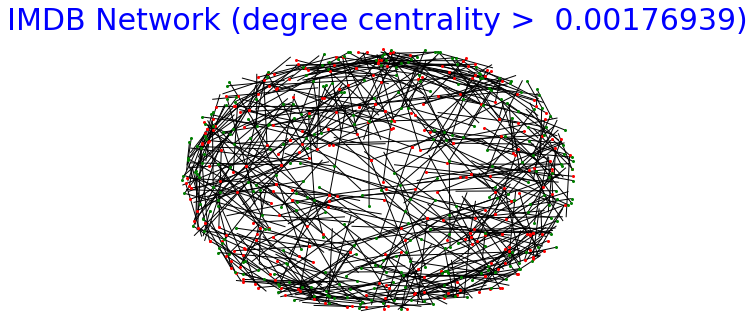

In [230]:
#graph the new network (high)
nx.draw(G3, nodelist = hMovies, node_color = 'r', node_size = 4)
nx.draw(G3, nodelist = hActors, node_color = 'g', node_size = 4)
plt.title('IMDB Network (degree centrality >  0.00176939)', fontsize = 30, color = 'blue')
plt.show()
#The weight chosen in the above algorithm was the midpoint of all our weights taken from
#the weight which were visualized above

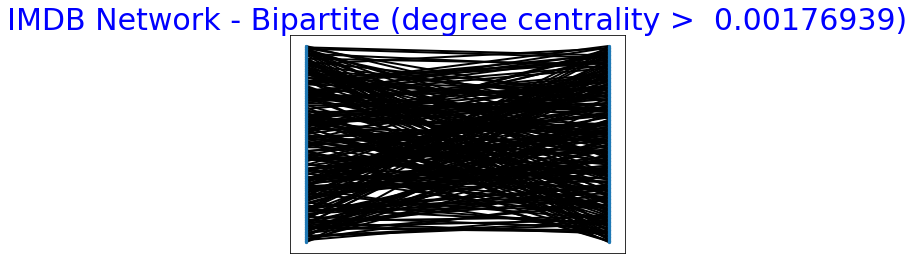

In [231]:
# draw the graph using the bipartite layout to show connections
nx.draw_networkx(G3, node_size = 5, pos = nx.drawing.layout.bipartite_layout(G3, hMovies), width = 2, with_labels = False)
plt.title('IMDB Network - Bipartite (degree centrality >  0.00176939)', fontsize = 30, color = 'blue')
plt.show()

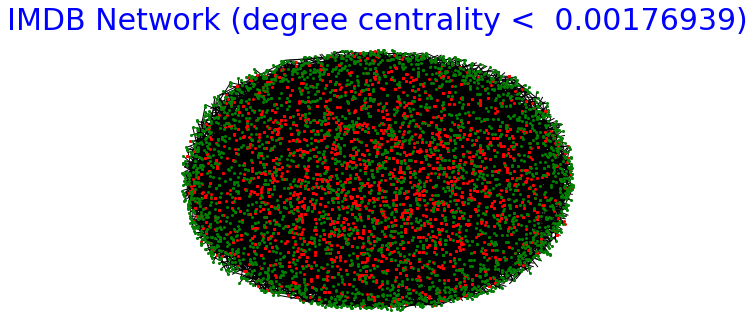

In [232]:
#graph the new network (low)
nx.draw(G4, nodelist = lMovies, node_color = 'r', node_size = 4)
nx.draw(G4, nodelist = lActors, node_color = 'g', node_size = 4)
plt.title('IMDB Network (degree centrality <  0.00176939)', fontsize = 30, color = 'blue')
plt.show()

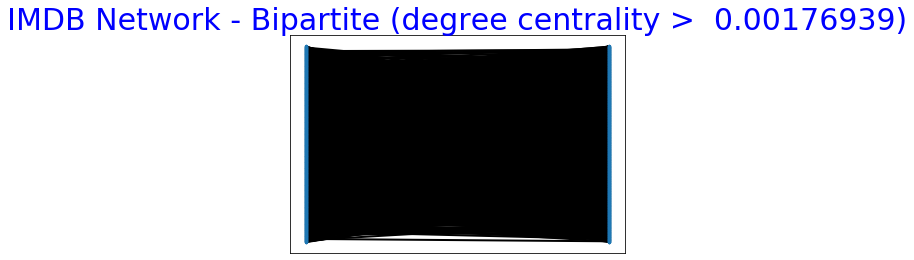

In [233]:
# draw the graph using the bipartite layout to show connections
nx.draw_networkx(G4, node_size = 5, pos = nx.drawing.layout.bipartite_layout(G4, lMovies), width = 2, with_labels = False)
plt.title('IMDB Network - Bipartite (degree centrality >  0.00176939)', fontsize = 30, color = 'blue')
plt.show()

Here it is easy to see that by using the island method we have reduced the network substacially leaving those edges with greater influence (weight) in G3 and most weaker influence (weight) in G4. Below we implement the island method on the largest subgraph in our network using the 10 distinct edge weights as steps for our water level. The following <code>island_method</code> function returns a list of networks with connections that have the same weight as the water level. 

In [285]:
#create a list of all the unique weights (based on the histogram of weights above there only should be)
#about 10
uniqueWeightList = np.array(weightList)
uniqueWeightList = np.unique(uniqueWeightList)
# We can also do this for various water levels so that we have a list of networks at each level
#since we have a discrete set of unique weights we can raise the water level by weight

#This will return a list of graph objects corresponding to a water level
#Each water level corresponds to the edge weights specified in uniqueWeightList
graphs = []
def island_method(g, weightList):
    #grab the edge data
    edgeData = list(g.edges(data=True))
    #generate 10 graph objects
    for i in range(len(uniqueWeightList)):
        graphs.append(nx.Graph())
    
    #check for weights in each category
    for f, to, w in edgeData:
        for i in range(len(weightList)):
            if w['weight'] == weightList[i]:
                graphs[i].add_edge(f,to,weight = w['weight'])
    return graphs

#create subgraphs of each component
S = [G2.subgraph(c).copy() for c in nx.connected_components(G2)]

#check to see if the first item in the list is the largest subgraph
#We can see that this subgraph has 2620 nodes which matches our histogram
#We'll apply the island method to the largest fully connected subgraph
print(nx.info(S[0]))

Name: 
Type: Graph
Number of nodes: 2620
Number of edges: 3356
Average degree:   2.5618


(array([426.,  58.,  19.,  10.,   8.,   4.,   3.,   2.,   0.,   1.]),
 array([ 2. ,  4.2,  6.4,  8.6, 10.8, 13. , 15.2, 17.4, 19.6, 21.8, 24. ]),
 <a list of 10 Patch objects>)

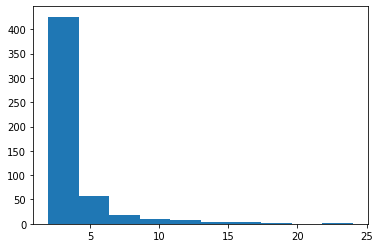

In [295]:
#apply the island method to largest subgraph
islandGraphs = island_method(S[0], uniqueWeightList)

#plot the distribution of components for first island
x=[len(c) for c in nx.connected_components(islandGraphs[0])]
plt.hist(x)

Name: 
Type: Graph
Number of nodes: 1924
Number of edges: 1396
Average degree:   1.4511
Name: 
Type: Graph
Number of nodes: 1032
Number of edges: 589
Average degree:   1.1415
Name: 
Type: Graph
Number of nodes: 638
Number of edges: 358
Average degree:   1.1223
Name: 
Type: Graph
Number of nodes: 553
Number of edges: 297
Average degree:   1.0741
Name: 
Type: Graph
Number of nodes: 470
Number of edges: 279
Average degree:   1.1872
Name: 
Type: Graph
Number of nodes: 291
Number of edges: 165
Average degree:   1.1340
Name: 
Type: Graph
Number of nodes: 162
Number of edges: 86
Average degree:   1.0617
Name: 
Type: Graph
Number of nodes: 180
Number of edges: 95
Average degree:   1.0556
Name: 
Type: Graph
Number of nodes: 126
Number of edges: 69
Average degree:   1.0952
Name: 
Type: Graph
Number of nodes: 42
Number of edges: 22
Average degree:   1.0476


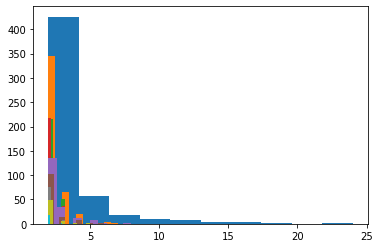

In [296]:
for i in range(len(islandGraphs)):
    #print the basic information about each subgraph
    print(nx.info(islandGraphs[i]))
    # plot the histogram for each component of each island
    x=[len(c) for c in nx.connected_components(islandGraphs[i])]
    plt.hist(x)

Above we can see a print out of information for each network slice that was taken via the island methosd. We can see that as that each network has different average degree centrality and as the water level rises the number of connections islated decreases thereby reducing the network. All networks generate contain close to 1 average degree centrality indicating that these networks contain groups of similar nodes and edges. In addition we can begin to extract more insights from each subgraph. Below we can compare the movies and actor included in the frst subgraph (lowest weight) and last subgraph (highest weight). We can also visualize these networks so we can analyze the shape of each and how they contribute to the whole.

In [340]:
#List of connections in first subgraph weight = 0.0002949
list(islandGraphs[0])[0:9]

['Guardians of the Galaxy',
 ' Zoe Saldana',
 'Prometheus',
 ' Charlize Theron',
 'Split',
 ' Jessica Sula',
 'Sing',
 ' Scarlett Johansson',
 'Suicide Squad']

In [341]:
#List of connections in last subgraph weight = 0.0032438808611029196
list(islandGraphs[9])[0:9]

['Guardians of the Galaxy',
 'Chris Pratt',
 'Prometheus',
 'Noomi Rapace',
 'Split',
 'James McAvoy',
 'Sing',
 'Matthew McConaughey',
 'Suicide Squad']

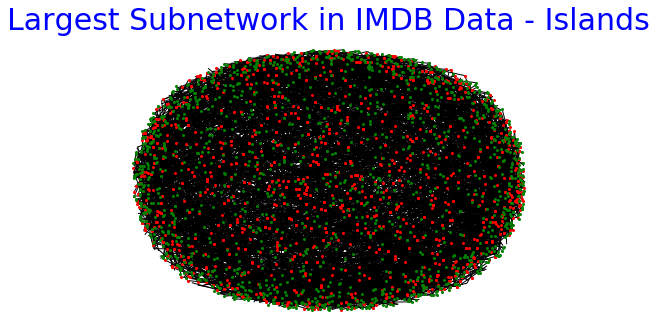

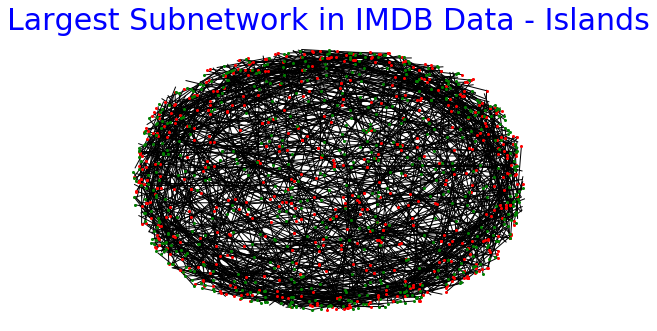

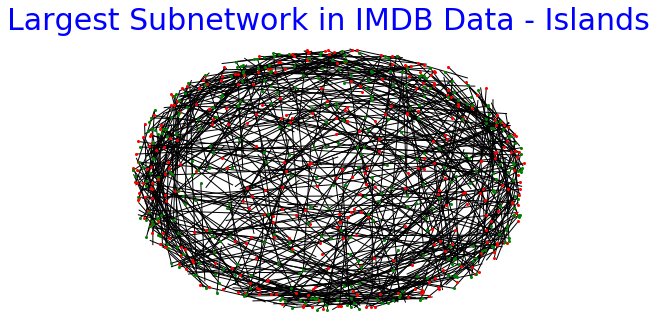

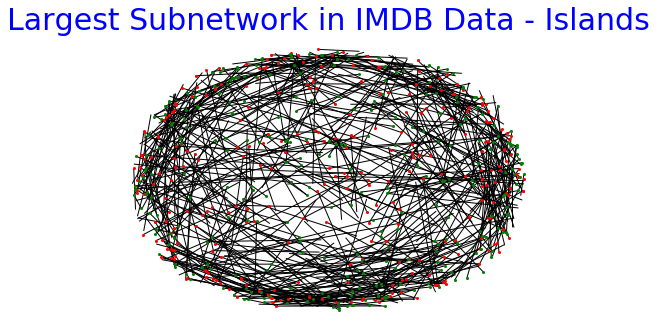

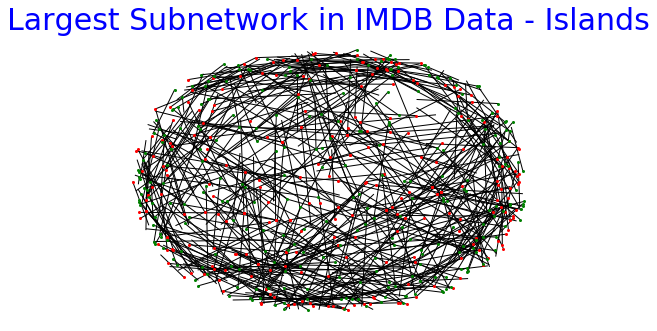

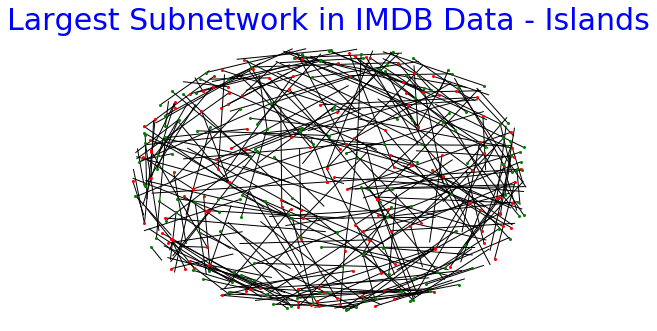

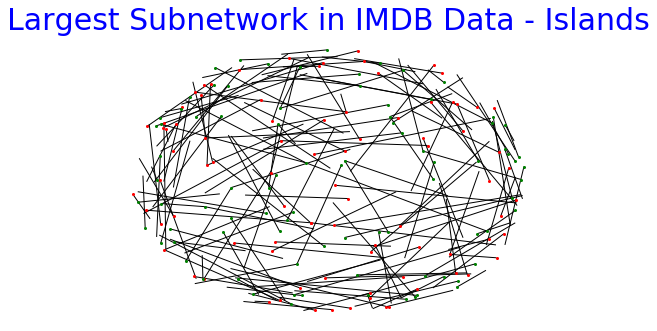

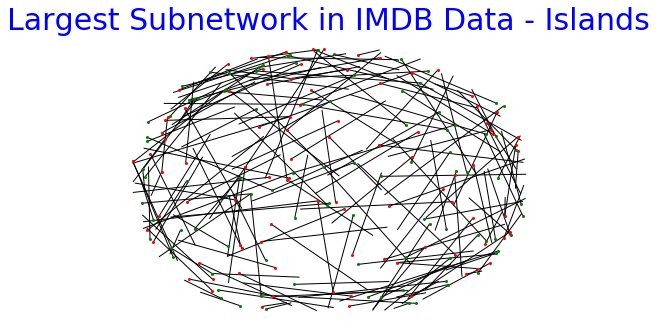

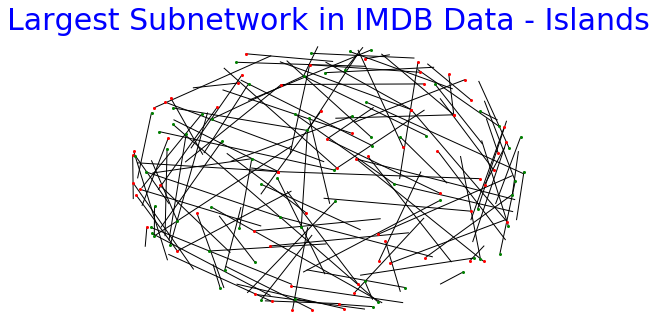

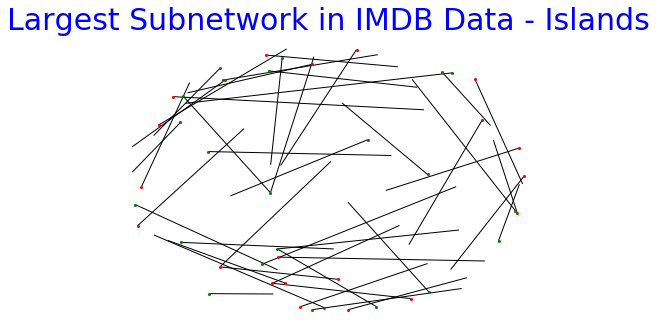

In [345]:
#plot the networks
for i in islandGraphs:
    edgeList = list(i.edges(data = True))
    movies = []
    actors = []
    for j in range(len(edgeList)):
        movies.append(edgeList[j][0])
        actors.append(edgeList[j][1])
        #weights.append(edgeList[i][2]['weight'])
    
    #graph the network
    nx.draw(i, nodelist = movies, node_color = 'r', node_size = 4)
    nx.draw(i, nodelist = actors, node_color = 'g', node_size = 4)
    plt.title('Largest Subnetwork in IMDB Data - Islands', fontsize = 30, color = 'blue')
    plt.show()
    

In [ ]:
#plot the networks
for i in islandGraphs:
    edgeList = list(i.edges(data = True))
    movies = []
    actors = []
    for j in range(len(edgeList)):
        movies.append(edgeList[j][0])
        actors.append(edgeList[j][1])
        #weights.append(edgeList[i][2]['weight'])
    # draw the graph using the bipartite layout to show connections
    nx.draw_networkx(i, node_size = 5, pos = nx.drawing.layout.bipartite_layout(i, movies), width = 2, with_labels = False)
    plt.title('Largest Subnetwork in IMDB Data - Bipartite' + str(uniqueWeightList[i]), fontsize = 30, color = 'blue')
    plt.show()
    
    

## Conclusion
Network reduction via the island method is a very effective we to reduce a network into smaller subneworks for better analysis. To expand this project we can possibly identify a similarity matrix that will shows us some comparisons between movies and between actors. We can use this information to gather insight on the strongest and most well connected actors and their associated movies.
